# Notebook per regressione lineare

Di seguito:
- verrà implementato l'algoritmo di regressione logistica

## Scaricamento dei dati

In [1]:
# File per scaricare i dati per fare analisi di machine learning

import requests
import zipfile
import io
import os

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip",
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_validation_data.zip",
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_test_data.zip",
]

# Directory to save the extracted files
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    try:
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Read the zip file from the response content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all contents to the specified output directory
            zip_ref.extractall(output_dir)
            print(f"Extracted files from {url} to {output_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file from {url} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

print("Download and extraction complete.")

# Now you can access your CSV files in the 'downloaded_data' directory
# For example, to list the files in the directory:
import glob
csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print("CSV files found:", csv_files)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to dataset
Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_validation_data.zip to dataset
Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_test_data.zip to dataset
Download and extraction complete.
CSV files found: ['dataset/X_train.csv', 'dataset/y_train.csv', 'dataset/X_test.csv', 'dataset/X_validation.csv']


## Creazione variabile dati

Prendo i dati (per la challenge era relativa al solo train) dalla cartella e creo la variabile contenente tutti i dati e lo stato di salute delle turbine.

In [2]:
import pandas as pd

def load_data(x_path, y_path):
  """
  Loads X.csv and the second column of y.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X.csv file.
    y_path (str): The path to the y.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X.csv
                      and the second column of y.csv.
  """
  x = pd.read_csv(x_path)
  y = pd.read_csv(y_path)

  # Assuming y has at least 2 columns and the second column is at index 1
  if y.shape[1] > 1:
    combined_data = x.copy()
    combined_data['y_target'] = y.iloc[:, 1]
    return combined_data
  else:
    print("Error: y.csv does not have a second column.")
    return x

# Example usage:
# Assuming your files are in the 'dataset' directory as per the preceding code
x_path = 'dataset/X_train.csv'
y_path = 'dataset/y_train.csv'

data = load_data(x_path, y_path)

# You can now work with the 'data' DataFrame
print(data.head())


   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  y_target  
0   99.6400         1  
1   91.3866         0  
2   90.9600         1  
3  100.2800         0  
4   92.1700         0  


## Creazione training set, test set

In [4]:
from sklearn.model_selection import train_test_split

data_train1, data_test = train_test_split(data, test_size=0.2, random_state=42)

print("Dimensione data_train:", data_train1.shape)
print("Dimensione data_test:", data_test.shape)

Dimensione data_train: (594100, 9)
Dimensione data_test: (148525, 9)


## Cambio dei nomi delle feature

In [6]:
def rename_dataframe_columns(df, new_column_names):
  """
  Renames the columns of a pandas DataFrame.

  Args:
    df: The pandas DataFrame whose columns are to be renamed.
    new_column_names: A list of new column names. The length of this list
                      must match the number of columns in the DataFrame.

  Returns:
    The DataFrame with renamed columns.
  """
  if len(new_column_names) != len(df.columns):
    raise ValueError("The number of new column names must match the number of existing columns.")
  df.columns = new_column_names
  return df

# Example usage:
# Assuming you have a list of new names for your columns
new_names_for_train_data = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state'] # Replace with your desired names

# Rename the columns of data_train
# Ensure the number of names in new_names_for_train_data matches the number of columns in data_train
print(f"Number of columns in data_train: {len(data_train1.columns)}")
print(f"Number of new names provided: {len(new_names_for_train_data)}")

data_train = rename_dataframe_columns(data_train1, new_names_for_train_data)
print("\nDataFrame after renaming columns:")
print(data_train.head())

Number of columns in data_train: 9
Number of new names provided: 9

DataFrame after renaming columns:
           idx  torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067  331067      74.8000            19.500       646.1000    1005.8400   
601458  601458      67.0332            20.152       602.4063     958.4962   
77053    77053      67.8000             8.000       546.7000      24.3840   
664037  664037      53.9000             5.500       532.1000     360.8832   
346977  346977      73.3000            17.750       636.3000    1025.9570   

        indicated_air_speed  net_power  compressor_speed  health_state  
331067             56.00000  100.19000          96.47000             1  
601458             96.97656   99.65235          94.02332             0  
77053              73.68750  100.22000          91.61000             0  
664037             61.87500   88.91000          99.78000             0  
346977             89.50000   99.98000          95.95000             1

In [7]:
data_train, data_validation = train_test_split(data_train1, test_size=0.2, random_state=42)

print("Dimensione data_train:", data_train.shape)
print("Dimensione data_test:", data_test.shape)

Dimensione data_train: (475280, 9)
Dimensione data_test: (148525, 9)


# Pipeline

   torque_meas  outside_air_temp  mean_gas_temp  \
0     0.437796          0.379132       0.301445   
1     0.388105          0.775611       0.434144   
2     0.414477          0.468339       0.385787   
3     0.529960          0.472799       0.362358   
4     0.535512          0.758263       0.493557   

   power_avail_root_2.35_transformed  indicated_air_speed_binned_5_quantile  \
0                           0.483366                                   0.25   
1                           0.817840                                   0.00   
2                           0.859217                                   0.25   
3                           0.512556                                   0.25   
4                           0.375913                                   0.25   

   compressor_speed_net_power_pca  torque_times_temp  y_target  
0                        0.202284           0.377608         1  
1                        0.887659           0.594078         0  
2                      

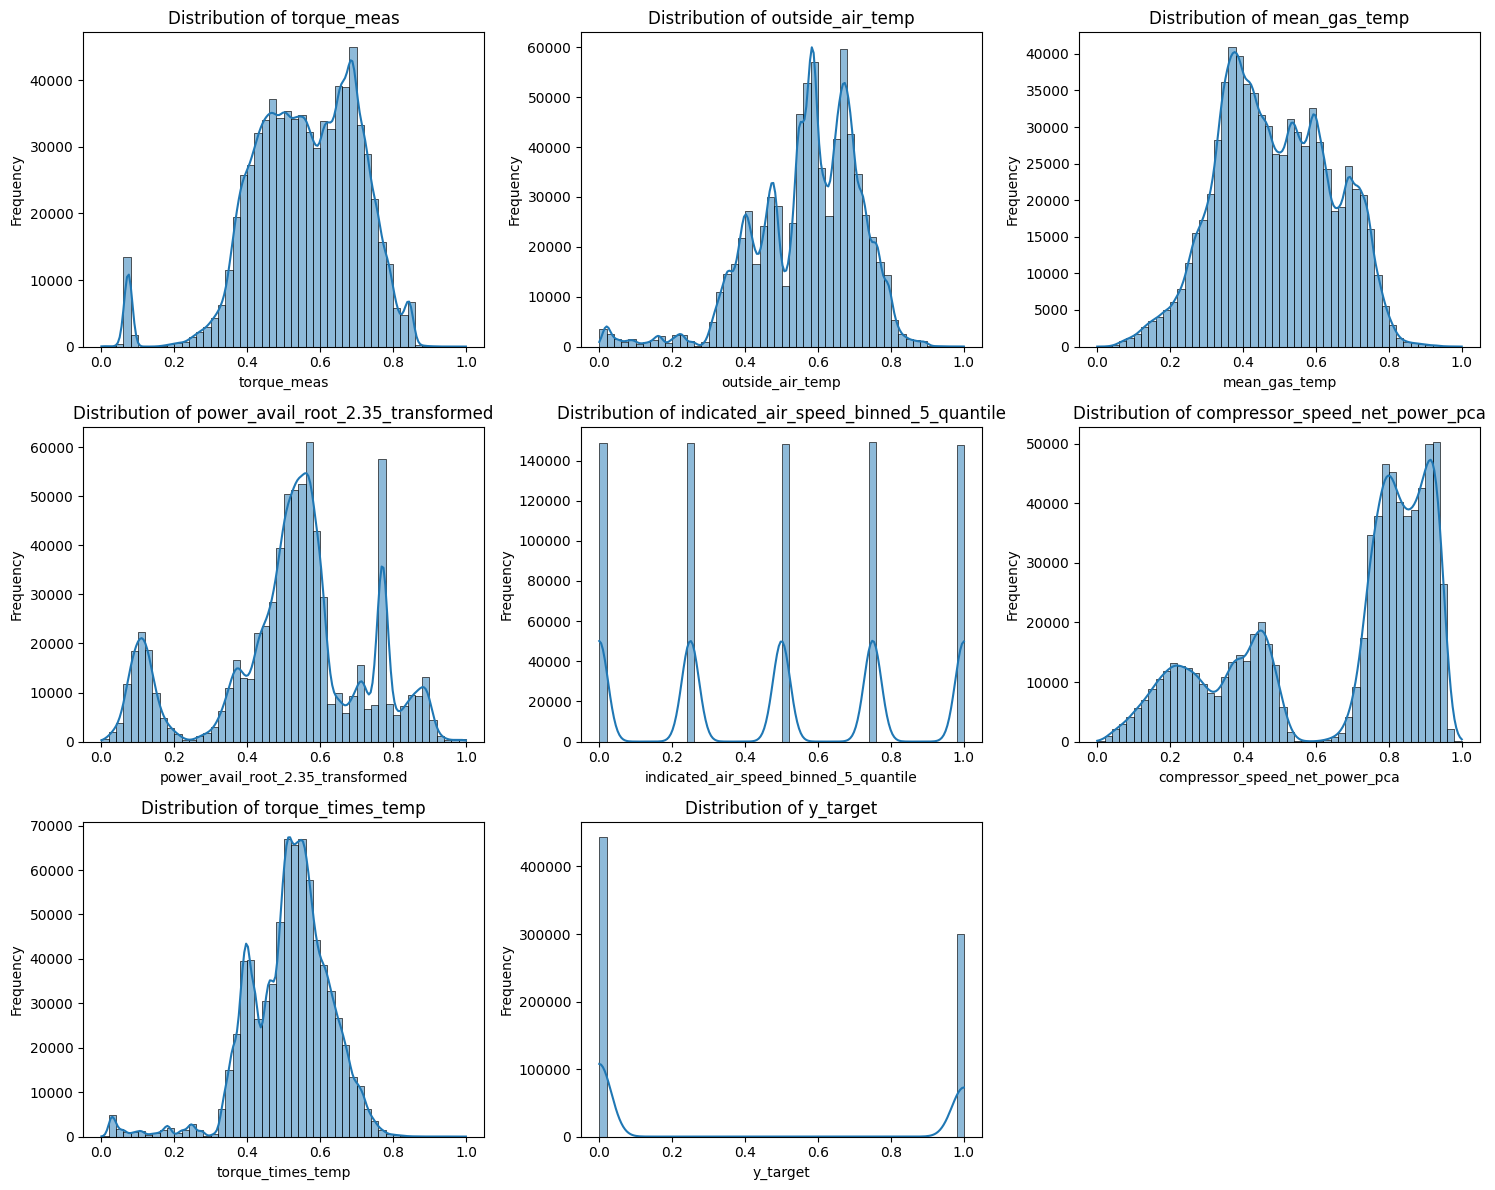

In [8]:
# Useful package
import requests
import zipfile
import io
import os

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns



# Code for preprocessing of the dataset and for the pipeline

def load_training_data(x_path, y_path):
  """
  Loads X_train.csv and the second column of y_train.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X_train.csv file.
    y_path (str): The path to the y_train.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X_train.csv
                      and the second column of y_train.csv.
  """
  x_train = pd.read_csv(x_path)
  y_train = pd.read_csv(y_path)

  # Assuming y_train has at least 2 columns and the second column is at index 1
  if y_train.shape[1] > 1:
    combined_data = x_train.copy()
    combined_data['y_target'] = y_train.iloc[:, 1]
    return combined_data
  else:
    print("Error: y_train.csv does not have a second column.")
    return x_train

# x_train_path = 'dataset/X_train.csv'
# y_train_path = 'dataset/y_train.csv'

# data_train = load_training_data(x_train_path, y_train_path)



def rename_dataframe_columns(df, new_column_names):
  """
  Renames the columns of a pandas DataFrame.

  Args:
    df: The pandas DataFrame whose columns are to be renamed.
    new_column_names: A list of new column names. The length of this list
                      must match the number of columns in the DataFrame.

  Returns:
    The DataFrame with renamed columns.
  """
  if len(new_column_names) != len(df.columns):
    raise ValueError("The number of new column names must match the number of existing columns.")
  df.columns = new_column_names
  return df

# new_names_for_train_data = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state'] # Replace with your desired names

# data_train = rename_dataframe_columns(data_train, new_names_for_train_data)

# Aggiungere il drop della colonna di indice
# data_train = data_train.drop('idx', axis=1)


#######################################################################
#######################################################################
#######################################################################

# Da qui partono funzioni relative a trasformazioni di singole feature


def transform_with_custom_root(df, column_name, root_degree):
  """
  Applies a custom root transformation (1/root_degree power) to a column.
  Handles positive, negative, and zero values appropriately based on the root degree.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    root_degree (float): The degree of the root (e.g., 2 for square root, 3 for cube root).

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  new_column_name = f'{column_name}_root_{root_degree:.2f}_transformed'

  if root_degree == 0:
      raise ValueError("Root degree cannot be zero.")
  elif root_degree % 2 == 0:  # Even root
      # For even roots, we can only take the root of non-negative numbers
      if (df[column_name] < 0).any():
          print(f"Warning: Column '{column_name}' contains negative values. Cannot apply even root directly.")
          # You might choose to handle this by taking the root of the absolute value,
          # or setting negative values to NaN, depending on your data context.
          # Here, we'll take the root of the absolute value for demonstration.
          df[new_column_name] = np.power(np.abs(df[column_name]), 1/root_degree)
      else:
          df[new_column_name] = np.power(df[column_name], 1/root_degree)
  else:  # Odd root
      # Odd roots can handle positive, negative, and zero values
      df[new_column_name] = np.sign(df[column_name]) * np.power(np.abs(df[column_name]), 1/root_degree)

  return df

# Example usage with a custom root (e.g., 1.5)
# custom_root_degree = 2.35
# data_train = transform_with_custom_root(data_train.copy(), 'power_avail', custom_root_degree)


def create_binned_qualitative_variable(df, column_name, num_bins, strategy='quantile'):
  """
  Creates a qualitative (categorical) variable by binning a numerical column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the numerical column to bin.
    num_bins (int): The desired number of bins.
    strategy (str): The strategy to use for binning. 'quantile' uses quantiles
                    to ensure bins have approximately equal numbers of observations.
                    'uniform' creates bins with equal widths. Default is 'quantile'.

  Returns:
    pd.DataFrame: The DataFrame with a new qualitative column.
                  The new column name will be f'{column_name}_binned_{num_bins}_{strategy}'.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")
  if num_bins <= 1:
      raise ValueError("Il numero di bins deve essere maggiore di 1.")

  new_column_name = f'{column_name}_binned_{num_bins}_{strategy}'

  if strategy == 'quantile':
    # Use qcut to create bins based on quantiles (approximately equal number of observations)
    # `duplicates='drop'` handles cases where quantile boundaries are not unique,
    # which can happen with skewed or discrete data.
    df[new_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')
  elif strategy == 'uniform':
    # Use cut to create bins of equal width
    df[new_column_name] = pd.cut(df[column_name], bins=num_bins, labels=False, include_lowest=True)
  else:
    raise ValueError(f"Strategia di binning non valida: '{strategy}'. Scegliere tra 'quantile' o 'uniform'.")

  # Convert the binned column to object/category type if needed, or keep as int for simplicity
  # Here we keep it as int representing the bin number

  return df

# Example usage for 'indicated_air_speed':
# num_bins_indicated_air_speed = 5 # Define the number of bins
# binning_strategy = 'quantile' # Or 'uniform'

#data_train = create_binned_qualitative_variable(
#    data_train.copy(),
#    'indicated_air_speed',
#    num_bins_indicated_air_speed,
#    strategy=binning_strategy
#)




## PCA per indicated_air_speed e compressor_speed
# Select the columns for PCA
# features_for_pca = data_train[['compressor_speed', 'net_power']]
# Initialize PCA with 1 component (to combine the two variables)
# pca = PCA(n_components=1)
# Fit PCA on the selected features and transform them
# data_train['compressor_speed_net_power_pca'] = pca.fit_transform(features_for_pca)



## Creazione di torque_times_temp

# data_train['torque_times_temp'] = data_train['torque_meas'] * data_train['outside_air_temp']




# Standardizzazione
def standardize_columns(df, columns_to_standardize):
  """
  Standardizes specified columns of a pandas DataFrame to have values between 0 and 1
  using MinMaxScaler.

  Args:
    df: The pandas DataFrame to standardize.
    columns_to_standardize: A list of column names to standardize.

  Returns:
    The DataFrame with the specified columns standardized.
  """
  scaler = MinMaxScaler()
  df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
  return df

# Example usage:
# Assuming you want to standardize all numerical columns except the index and the target variable
# Identify numerical columns (excluding 'idx' and 'health_state' in this case)
# numerical_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
# columns_to_standardize = [col for col in numerical_cols if col not in ['idx', 'health_state']]





# Creazione pipeline
def prepare_data_pipeline(x_path, y_path, new_column_names=None,
                          root_transformations=None,
                          binning_config=None,
                          standardize=True,
                          drop_index_col='idx'):
    """
    Esegue la pipeline completa di preprocessing.

    Args:
        x_path (str): path al file X_train.csv
        y_path (str): path al file y_train.csv
        new_column_names (list): lista di nuovi nomi colonne (opzionale)
        root_transformations (dict): dict {colonna: radice}
        binning_config (dict): dict {colonna: (num_bins, strategia)}
        standardize (bool): se standardizzare le colonne numeriche
        drop_index_col (str): nome della colonna da droppare (opzionale)

    Returns:
        pd.DataFrame: DataFrame preprocessato pronto per il training
    """
    df = load_training_data(x_path, y_path)

    if new_column_names:
        df = rename_dataframe_columns(df, new_column_names + ['y_target'])

    if drop_index_col in df.columns:
        df = df.drop(drop_index_col, axis=1)

    # Trasformazioni custom root
    if root_transformations:
        for col, deg in root_transformations.items():
            df = transform_with_custom_root(df, col, deg)

    # Binning
    if binning_config:
        for col, (n_bins, strategy) in binning_config.items():
            df = create_binned_qualitative_variable(df, col, n_bins, strategy)

    # PCA: esempio hardcoded ma puoi parametrizzare se vuoi
    if {'compressor_speed', 'net_power'}.issubset(df.columns):
        pca = PCA(n_components=1)
        df['compressor_speed_net_power_pca'] = pca.fit_transform(df[['compressor_speed', 'net_power']])

    # Feature engineering manuale
    if {'torque_meas', 'outside_air_temp'}.issubset(df.columns):
        df['torque_times_temp'] = df['torque_meas'] * df['outside_air_temp']

    # Rimuovi colonne non necessarie
    columns_to_drop = ['compressor_speed','net_power','indicated_air_speed','power_avail']  # Aggiungi qui altre colonne da rimuovere
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Assicurati che 'y_target' sia l'ultima colonna
    if 'y_target' in df.columns:
        cols = [col for col in df.columns if col != 'y_target'] + ['y_target']
        df = df[cols]
    else:
        print("Warning: 'y_target' column not found in DataFrame. It will not be moved to the end.")

    # Assicurati che il DataFrame non abbia colonne duplicate
    df = df.loc[:, ~df.columns.duplicated()]

    # Assicurati che il DataFrame non abbia valori NaN
    if df.isnull().values.any():
        print("Warning: DataFrame contains NaN values. They will be filled with 0.")
        df = df.fillna(0)

    # Assicurati che il DataFrame non abbia valori infiniti
    if np.isinf(df.values).any():
        print("Warning: DataFrame contains infinite values. They will be replaced with 0.")
        df.replace([np.inf, -np.inf], 0, inplace=True)

    # Standardizzazione
    if standardize:
        target = 'y_target'
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        columns_to_standardize = [col for col in numerical_cols if col != target]
        df = standardize_columns(df, columns_to_standardize)

    return df



### Esempio di utilizzo della pipeline
x_path = 'dataset/X_train.csv'
y_path = 'dataset/y_train.csv'

# Configurazioni opzionali
new_column_names = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp',
                    'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']

root_transform = {'power_avail': 2.35}
binning = {'indicated_air_speed': (5, 'quantile')}

data_ready = prepare_data_pipeline(
    x_path, y_path,
    new_column_names=new_column_names,
    root_transformations=root_transform,
    binning_config=binning
)

# Esempio di stampa del DataFrame preprocessato
print(data_ready.head())
print(data_ready.describe())

n_cols = 3
n_rows = (len(data_ready.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(data_ready):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data_ready[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("grafico.png")

# data_ready ora è pronto per essere usato in un modello

# Regressione logistica

Starting 10-fold cross-validation...
--- Fold 1/10 ---
  Accuracy: 0.9267
  Precision: 0.9158
  Sensitivity: 0.9028
  Specificity: 0.9432
--- Fold 2/10 ---
  Accuracy: 0.9255
  Precision: 0.9131
  Sensitivity: 0.8991
  Specificity: 0.9430
--- Fold 3/10 ---
  Accuracy: 0.9251
  Precision: 0.9141
  Sensitivity: 0.9002
  Specificity: 0.9422
--- Fold 4/10 ---
  Accuracy: 0.9253
  Precision: 0.9105
  Sensitivity: 0.9023
  Specificity: 0.9407
--- Fold 5/10 ---
  Accuracy: 0.9262
  Precision: 0.9147
  Sensitivity: 0.9003
  Specificity: 0.9436
--- Fold 6/10 ---
  Accuracy: 0.9272
  Precision: 0.9159
  Sensitivity: 0.9037
  Specificity: 0.9433
--- Fold 7/10 ---
  Accuracy: 0.9254
  Precision: 0.9109
  Sensitivity: 0.9031
  Specificity: 0.9405
--- Fold 8/10 ---
  Accuracy: 0.9259
  Precision: 0.9159
  Sensitivity: 0.8995
  Specificity: 0.9438
--- Fold 9/10 ---
  Accuracy: 0.9255
  Precision: 0.9128
  Sensitivity: 0.8999
  Specificity: 0.9426
--- Fold 10/10 ---
  Accuracy: 0.9278
  Precision: 0.9

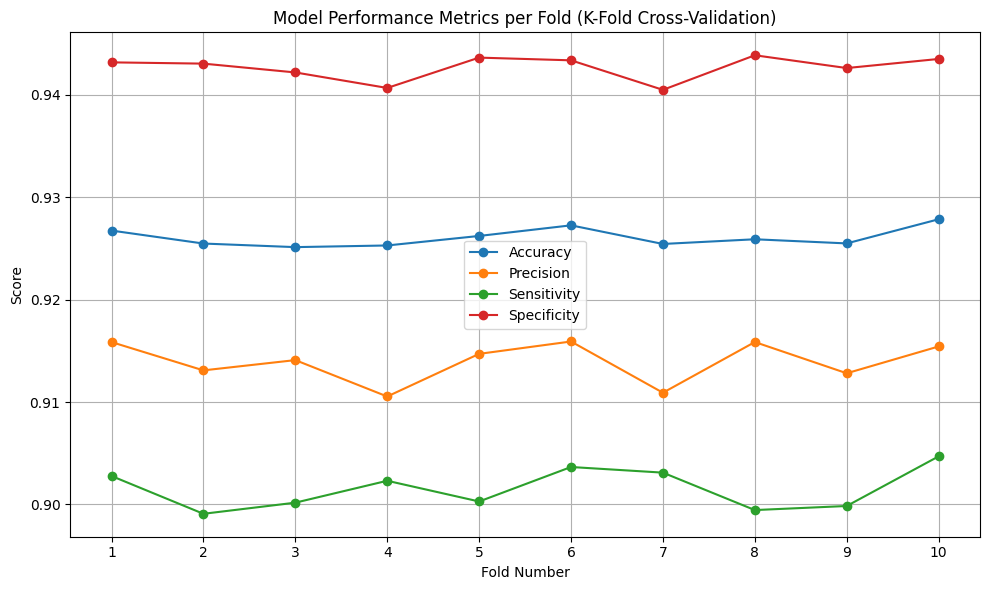

In [13]:
# prompt: utilizza una regressione logistica per predire la feature 'health_state' sulla base delle altre feature, dopo aver elaborato le feature tramite pipeline. utilizza k-fold validation. Plotta in una tabella precision, accuracy, sensitivity e specificity

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np

# Separate features (X) and target (y)
X = data_ready.drop('y_target', axis=1)
y = data_ready['y_target']

# Define the number of folds for K-Fold Cross-Validation
n_splits = 10  # You can adjust this number
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
sensitivity_scores = [] # Sensitivity is the same as Recall
specificity_scores = []

# Initialize the Logistic Regression model
# You can tune the hyperparameters here, e.g., C, solver, etc.
model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence

print(f"Starting {n_splits}-fold cross-validation...")

# Iterate over each fold
for fold, (train_index, validation_index) in enumerate(kf.split(X)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    # Split data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_test = y.iloc[train_index], y.iloc[validation_index]

    # Train the model on the training data for this fold
    model.fit(X_train, y_train)

    # Make predictions on the test data for this fold
    y_pred = model.predict(X_test)

    # Calculate metrics for this fold
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() # True Negatives, False Positives, False Negatives, True Positives

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0) # zero_division=0 handles cases with no positive predictions
    sensitivity = recall_score(y_test, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0 # Avoid division by zero

    # Store the metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Sensitivity: {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")


# Calculate the average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_sensitivity = np.mean(sensitivity_scores)
avg_specificity = np.mean(specificity_scores)

# Create a table to display the results
results = {
    'Metric': ['Accuracy', 'Precision', 'Sensitivity', 'Specificity'],
    'Average Score': [avg_accuracy, avg_precision, avg_sensitivity, avg_specificity]
}

# Add individual fold scores to the table for detailed view
for i in range(n_splits):
    results[f'Fold {i+1}'] = [accuracy_scores[i], precision_scores[i], sensitivity_scores[i], specificity_scores[i]]

results_df = pd.DataFrame(results)

print("\n--- Cross-Validation Results Table ---")
print(results_df.to_markdown(index=False, floatfmt=".4f")) # Use to_markdown for better display in Colab/Jupyter

# Optional: Plotting the metrics per fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_splits + 1), accuracy_scores, marker='o', linestyle='-', label='Accuracy')
plt.plot(range(1, n_splits + 1), precision_scores, marker='o', linestyle='-', label='Precision')
plt.plot(range(1, n_splits + 1), sensitivity_scores, marker='o', linestyle='-', label='Sensitivity')
plt.plot(range(1, n_splits + 1), specificity_scores, marker='o', linestyle='-', label='Specificity')
plt.title('Model Performance Metrics per Fold (K-Fold Cross-Validation)')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.xticks(range(1, n_splits + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
